## Is the ENTRP-SRCH dataset sufficently sized?

In this notebook we apply the LambdaMART, a pairwise learning to rank method, to a text search data set. We use the XGBoost implementation of LambdaMART. 

In [1]:
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
import graphviz
import matplotlib
import math

import xgboost as xgb


## Data

The data I use is the ENTRP-SRCH dataset.

The data is a LETOR-formatted, of the form: "reference lable (ie ranking given by human), query id, query-url pairs (length 8 feature vectors)".  
 

In [2]:
import glob
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/entrp-srch/ENTRP-SRCH-v14.txt


In [3]:
import glob
import os

list_of_files = glob.glob('/kaggle/input/*/*') # * means all if need specific format then *.csv
datafile = max(list_of_files, key=os.path.getmtime)
print(datafile)

/kaggle/input/entrp-srch/ENTRP-SRCH-v14.txt


In [4]:
#qid query
#1 asian
#2 biochemistry
#3 botany
#4 chaplaincy
#5 classics
#6 commercial
#7 dental
#8 Engineering
#9 English
#10 european studies
#11 genetics
#12 geology
#13 history
#14 italian
#15 microbiology
#16 philosophy
#17 religion
#18 sociology
#19 walton club
#20 zoology

# train subset
# 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17

# test subset
# 11,12,13,14,15,16,17

# vali subset
# 18,19,20

In [5]:
# load all data with column names
column_names=["Judgement","QID",'F1','F2','F3','F4','F5','F6','F7','F8']

all_data = pd.read_csv(datafile, delimiter=' ',index_col=False, header = None) #names=column_names, delimiter=' ')


all_data.head(5)


,0,1,2,3,4,5,6,7,8,9
0,5,qid:1,1:7.901979,2:0.17024133,3:0.0,4:0.0,5:34.0,6:6.0,7:1.080049,8:0.19
1,3,qid:1,1:7.886458,2:0.24574098,3:0.0,4:0.0,5:22.0,6:8.0,7:0.42990547,8:0.04
2,4,qid:1,1:6.097526,2:0.30741006,3:0.0,4:0.0,5:22.0,6:7.0,7:0.4299054,8:0.03
3,5,qid:1,1:8.518949,2:0.30792695,3:0.0,4:1.0,5:4.0,6:7.0,7:0.42990547,8:0.09
4,3,qid:1,1:4.9042683,2:0.31480822,3:0.0,4:0.0,5:22.0,6:9.0,7:0.42990544,8:0.0


In [6]:
def cleanup ():
    # ensure any train, test and vali data are empty to start with
    !rm -f train*.txt; rm -f test*.txt; rm -f vali*.txt; rm -f *.group; rm -f qids.txt; rm -f ENTRP-SRCH-v14.txt; rm -f data; rm -f data.txt
    #!ls -lrt

In [7]:
def create_files():
   print("creating train.txt, test.txt and vali.txt files")
   !for SITE in 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17; do grep "qid:${SITE} " ENTRP-SRCH-out.txt >> train.txt; done
   !for SITE in 11 12 13 14 15 16 17; do grep "qid:${SITE} " /kaggle/input/entrp-srch/ENTRP-SRCH-v14.txt  >> test.txt; done
   #!for SITE in 11 12 13 14 15 16 17; do grep "qid:${SITE} " ENTRP-SRCH-out.txt  >> test.txt; done
   !for SITE in 18 19 20; do grep "qid:${SITE} " /kaggle/input/entrp-srch/ENTRP-SRCH-v14.txt >> vali.txt; done
    

In [8]:
def get_size():
    with open(r"train.txt", 'r') as fp:
        x = len(fp.readlines())
        print('Training Size lines:', x) 

    with open(r"test.txt", 'r') as fp:
        x = len(fp.readlines())
        print('Test Size lines:', x) 
    
    with open(r"vali.txt", 'r') as fp:
        x = len(fp.readlines())
        print('Validation Size lines:', x) 
   



In [9]:
!ls -lrt

total 44
---------- 1 root root 42673 May 13 20:36 __notebook__.ipynb


In [10]:
# debug - verify data is in expected format
!head -1 train.txt; wc -l train.txt
!head -1 test.txt; wc -l test.txt
!head -1 vali.txt; wc -l vali.txt

head: cannot open 'train.txt' for reading: No such file or directory
wc: train.txt: No such file or directory
head: cannot open 'test.txt' for reading: No such file or directory
wc: test.txt: No such file or directory
head: cannot open 'vali.txt' for reading: No such file or directory
wc: vali.txt: No such file or directory


In [11]:
# prepare files for XGBoost (requires a different formatting than LETOR)
def create_xgbfiles():
 print("preparing files in XGBoost format")
 ## remove qid from the files.
 !sed 's/[[:space:]][a-z]*:[0-9]*//g' train.txt > train_dat.txt
 !sed 's/[[:space:]][a-z]*:[0-9]*//g' vali.txt > vali_dat.txt
 !sed 's/[[:space:]][a-z]*:[0-9]*//g' test.txt > test_dat.txt
 !echo "removed qids"
 # extract the qids to their own files
 !grep -oh "qid:[0-9]*" train.txt > qids.txt
 !grep -oh "qid:[0-9]*" test.txt > test_qids.txt
 !grep -oh "qid:[0-9]*" vali.txt > vali_qids.txt
 !echo "extracted qids"
 ## make freq table from qids
 !uniq -c qids.txt > train_dat1.txt.group
 !uniq -c test_qids.txt > test_dat1.txt.group
 !uniq -c vali_qids.txt > vali_dat1.txt.group
 !echo "made frequency tables"
 ## extract first entry from frequency table
 !awk -F " " '{print $1}' train_dat1.txt.group > train_dat.txt.group
 !awk -F " " '{print $1}' test_dat1.txt.group > test_dat.txt.group
 !awk -F " " '{print $1}' vali_dat1.txt.group > vali_dat.txt.group

# !wc -l *   # debug

In [12]:
!ls -lrt

total 44
---------- 1 root root 43685 May 13 20:36 __notebook__.ipynb


In [13]:
#!uniq -c qids.txt   # debug

In [14]:
def create_pd ():
    training_data_set = pd.read_csv('train_dat.txt', sep = ' ', header = None) 
    testing_data_set = pd.read_csv('test_dat.txt', sep = ' ', header = None)
    training_size = len(training_data_set)
    print('TRAINING SIZE:', training_size) 
    testing_size = len(testing_data_set)
    print('TESTING SIZE:', testing_size) 
    


In [15]:
#df = df.sample(frac=0.50)

## Building a Model

We now set the model parameters:

'max_depth' = number of layers in the tree
'eta' = step shrinkage size, used to prevent overfitting
'silent' = if 1, doesn't print updates. 
'objective' = which method is used/which objective function is minimised. 'rank:pairwise' implements LambdaMART.
'num_round' = number of boosting rounds. 

* rank:pairwise: Use LambdaMART to perform pairwise ranking where the pairwise loss is minimized 
* rank:ndcg: Use LambdaMART to perform list-wise ranking where Normalized Discounted Cumulative Gain (NDCG) is maximized

## Visualising the model

The model takes the form of a decision tree, where splits at nodes are conditional on the inputted features in the feature vector for each query.  

In [16]:
def visualise_model ():
    print("Visualizing the Model with matplotlib")
    %matplotlib inline
    xgb.plot_tree(model, num_trees=3)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(150, 100)
    ax = xgb.plot_importance(model, color='red')
    fig = ax.figure
    fig.set_size_inches(20, 20)

It is possible to look a the importance of each of the 6 features within the model. In the feature plot below we see that the most 'important' feature in determining the output of the model for a given input is feature 1 (BM25)


* feature 1: BM25  (like tf-idf, but with a probablistic twist)
* feature 2: documentRecency (last modification date)
* feature 3: isContact  (url contains the word 'contact')
* feature 4: isAbout    (url contains keyword 'about')
* feature 5: rawHits    (a measure of document popularity)
* feature 6: urlLength  (number of terms in url path hierarchy)
* feature 7: linkRank  (Like Google's PageRank, but for ES)
* feature 8: clickThru  (CTR rate taken over a six-month period)



## Making predictions

'preds' contains predicted relelvance values for all of the queries in the testing data set. We want to compute the normalised discounted cumulative gain, or ndgc, of the results, in order to quantify the goodness of the model. This will allow us to compare models and tuning parameters. 

Predictions are made by passing a feature vector from the testing data set through the decision tree, ending at a leaf which gives a numerical value. The numerical value represents the relavance of that document for that query. 

In [17]:
#preds = model.predict(testing_data)

#  Normal Distributed Cumulative Gain 
ndcg is a metric commonly used to rate the output of learning to rank models.
ndcg is a measure of the relative goodness of the output of the ranking algorithm, and takes value between 0 and 1, with a 1 denoting that the algorithm has optimally ordered the pages for a query, and a 0 denoting that the pages have been reverse ordered. 

In [18]:
""" this returns 0 if all of the ordered data is undesirable"""
def ndcg_p(ordered_data, p):
    """normalised discounted cumulative gain"""
    if sum(ordered_data)==0:
        return 0
    else:
        indexloop = range(0, p)
        DCG_p = 0
        for index in indexloop:
            current_ratio=(2**(ordered_data[index])-1)*(math.log((float(index)+2), 2)**(-1))
            DCG_p = DCG_p + current_ratio
        ordered_data.sort(reverse=True)  
        K = len(ordered_data)
        indexloop = range(0, K)
        iDCG_p = 0
        for index in indexloop:
            current_ratio=(2**(ordered_data[index])-1)*((math.log((index+2), 2))**(-1))
            iDCG_p = iDCG_p + current_ratio
        return(DCG_p/iDCG_p)

In [19]:
#!cat train_dat.txt.group | wc -l  # debug, should be 20 queries

In [20]:

def ndcg_compute (length):
    f = open('vali_dat.txt.group', 'r')
    x = f.readlines()
    groups =[]
    for line in x:
        groups.append(int(line))
    f.close()
    testing_labels = testing_data.get_label()
 
    ## compute ndgc for each query.
    nquerys=range(0,len(groups))
    lower=0
    upper=0
    ndcgs=[]
    for i in nquerys:
        many=groups[i]
        upper = upper+many
        predicted = preds[lower:upper]
        labled = testing_labels[lower:upper]
        ordered = [x for _,x in sorted(zip(predicted,labled), reverse=True)]
        result = ndcg_p(ordered, many)
        ndcgs.append(result)
        lower=upper
    #ndcgs # debug
    #print (ndcgs)

In [21]:
#!cat vali_dat.txt.group

In [22]:
#ndcg_compute (y)

In [23]:
# evaluate using the nDCG metric
def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.

def ndcg_at_k(r, k, method=0):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

# **nDCG Scores**

In [24]:
#def ndcg_list(length):
#    print("Generating the ndcg scores for " +str(length))                  


# ****nDCG Plot****

In [25]:
def ndcg_plot():
 import seaborn as sns
 import matplotlib.pyplot as plt
 sns.set(rc = {'figure.figsize':(15,8)})
 
 all_ndcg = pd.read_csv('ndcg.txt', sep = ' ')

 #calculate average y-value
 #average = np.nanmean(all_ndcg.nDCG) 


 ax = sns.lineplot(y='nDCG', x='length', 
                   #estimator=np.median, 
                   #ci=None, 
                   #marker='o', 
                   data=all_ndcg) 
                   #palette=["C0", "grey", "k", "blue"], 
                   #hue='cutoff')


    
    
 ax.set_xlabel("Training QD-pairs")
 ax.set_ylabel("Average nDCG %")
 ax.set_title("Average nDCG score for various training dataset sizes.",fontsize=14, weight='bold') 

 #sns.set(style="whitegrid", color_codes=True)

 hatches = [".", "\\\\", "|"]
 # Loop over the bars
 for bars, hatch in zip(ax.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)
 # create the legend again to show the new hatching
 #ax.legend(title='nDCG@cutoff, where')

 plt.show()



In [26]:
!head -3 ENTRP-SRCH-out.txt
#!grep "2:0.17024133"  ENTRP-SRCH-out.txt


head: cannot open 'ENTRP-SRCH-out.txt' for reading: No such file or directory


In [27]:
!head -3 /kaggle/input/entrp-srch/ENTRP-SRCH-v14.txt
#!grep "2:0.31919777" /kaggle/input/entrp-srch/ENTRP-SRCH-v14.txt


5 qid:1 1:7.901979 2:0.17024133 3:0.0 4:0.0 5:34.0 6:6.0 7:1.080049 8:0.19
3 qid:1 1:7.886458 2:0.24574098 3:0.0 4:0.0 5:22.0 6:8.0 7:0.42990547 8:0.04
4 qid:1 1:6.097526 2:0.30741006 3:0.0 4:0.0 5:22.0 6:7.0 7:0.4299054 8:0.03


In [28]:
!wc -c ENTRP-SRCH-out.txt /kaggle/input/entrp-srch/ENTRP-SRCH-v14.txt

wc: ENTRP-SRCH-out.txt: No such file or directory
195362 /kaggle/input/entrp-srch/ENTRP-SRCH-v14.txt
195362 total


## **MAIN**

In [29]:

df_ndcg = pd.DataFrame(columns=['length','nDCG','cutoff'])


step = 2
print ("Step is:",step, "% of lines")

for i in range(0, 99, step):
    y= 1 - (i / 101.0)
    print ("Y is ",y)
    cleanup ()
    data = all_data.sample(frac=y)
    length = len(data.index) 
    print ("LENGTH:",length)
    data.to_csv('/kaggle/working/ENTRP-SRCH-out.txt', sep=' ', encoding='utf-8', index=False, header=None)    
    create_files()
    get_size()
    create_xgbfiles ()
    create_pd ()
    print("Commencing XGB DMatrix creation")
    training_data = xgb.DMatrix('train_dat.txt') 
    testing_data = xgb.DMatrix('test_dat.txt') 
    print("Building the XGB Model")
    param = {'max_depth':10, 'eta':0.3, 'objective':'rank:pairwise', 'num_round':15}
    model = xgb.train(param, training_data)
    #visualise_model ()
    preds = model.predict(testing_data)
    #print (preds)  
    cutoffs = [1,3,5,10,20] 
    for x in cutoffs: 
      new_row = {'cutoff':x,'length':length,'nDCG':ndcg_at_k(preds,x, method=1)} 
      df_ndcg = df_ndcg.append(pd.Series(new_row), ignore_index=True) # , index=df_ndcg.columns[:len(new_row)]), ignore_index=True)
      df_ndcg.to_csv('ndcg.txt', sep=' ', encoding='utf-8', index=False)


!cat ndcg.txt

Step is: 2 % of lines
Y is  1.0
LENGTH: 2554
creating train.txt, test.txt and vali.txt files
Training Size lines: 2169
Test Size lines: 963
Validation Size lines: 385
preparing files in XGBoost format
removed qids
extracted qids
made frequency tables
TRAINING SIZE: 2169
TESTING SIZE: 963
Commencing XGB DMatrix creation
[20:36:35] 2169x9 matrix with 17352 entries loaded from train_dat.txt
[20:36:35] 17 groups are loaded from train_dat.txt.group
[20:36:35] 963x9 matrix with 7704 entries loaded from test_dat.txt
[20:36:35] 7 groups are loaded from test_dat.txt.group
Building the XGB Model
[20:36:35] WARNING: /workspace/src/learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Y is  0.9801980198019802
LENGTH: 2503
creating train.txt, test.txt and

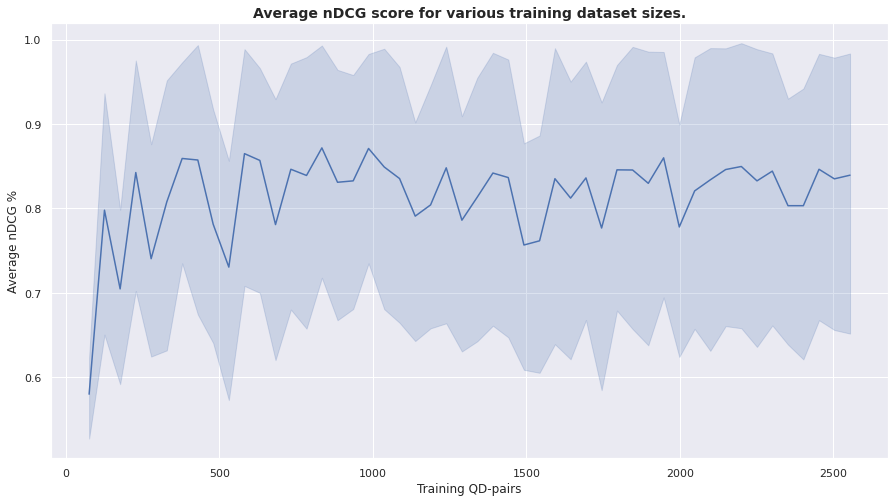

In [30]:
ndcg_plot()

In [31]:
# ndcg@5 
# 17 - 0.9488
# 16 - 0.927
# 15 - 0.922
# 14 - 0.934
# 13 - 0.952
# 12 - 0.949
# 11 - 0.946
# 10 - 0.833
# 9  - 0.923
# 8  - 0.911
# 7  - 0.722
# 6  - 0.795
# 5  - 0.835
# 4  - 0.838
# 3  - 0.743
# 2  - 0.687
# 1  - 0.692

